# Learning Goals

The goal of this assignment is to develop an understanding of how the brain performs computations at the neuronal level. To do so, you will develop several models of a spiking neuron. By the end of this assignment, you should a) be comfortable with developing models of spiking neurons at different levels of abstraction, from the biologically plausible H-H model to the phenomenological LIF model; b) understand how neurons use their firing rate to represent continuous-valued information; and c) understand the trade-offs involved in spike-based information representation.

*More theoretical information can be found here: https://neuronaldynamics.epfl.ch/online/Ch2.html*

Let's first import all the libraries required for this assignment

In [1]:
import math
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import torchvision
import torchvision.datasets as datasets
from torchvision import transforms

# Question 1: The Hodgkin Huxley Neuron

Before proceeding, please thoroughly review the [WIKI link](https://en.wikipedia.org/wiki/Hodgkin%E2%80%93Huxley_model)  and the research paper by Hodgkin and Huxley titled [Hodgkin A L, Huxley A F. A quantitative description of membrane current and its application to conduction and excitation in nerve, 1952](./HH.pdf). All necessary information for the Question 1 can be found in these sources. Additionally, please note the following:

1. To ensure depolarization is interpreted as a positive event, indicating the influx of positive ions into a neuron resulting in increased positivity at points of equilibrium voltage or constant, the sign on relevant variables should be reversed.
2. Utilize the formulas provided in the Wikipedia article as a framework for the code. (The formulas have been adjusted the notation in accordance with the reversal described in point 1).
3. Attempt to comprehend the underlying logic derived from the formulas rather than solely seeking the solution. By doing so, you'll seize the chance to grasp the intricacies of Nobel Prize-worthy research.


## 1a.

We will start by implementing the different computational models of a spiking neuron, with the aim of understanding the differences between the different models. We will start with one of the earliest, yet one of the most biologically faithful models of a neuron - The Hodgkin-Huxley (HH) model. Below is the class definition of an HH neuron. Your first task is to fill the different components required to simulate an HH neuron.


In [2]:
class HodgkinHuxley():
    """Implementation of Hodgkin Huxley Model"""
    def __init__(self, C_m, g_Na, g_K, g_L, E_Na, E_K, E_L, T, dt, reset, I_inj):
        """
        :param C_m: membrane capacitance in uF/cm^2
        :param g_Na: Sodium conductance in mS/cm^2
        :param g_K: Potassium conductance in ms/cm^2
        :param g_L: Leak maximum conductance
        :param E_Na: Sodium Nernst reversal potential in mV
        :param E_K: Potassium Nernst reversal potential in mV
        :param E_L: Leak Nernst reversal potential in mV
        :param T: Simulation timesteps
        :param dt: Integration time
        :param reset: Reset potential
        :param I_ink: injected current

        This function is complete. You do not need to do anything here.
        """
        self.C_m = C_m
        self.g_Na = g_Na
        self.g_K = g_K
        self.g_L = g_L
        self.E_Na = E_Na
        self.E_K = E_K
        self.E_L = E_L
        self.T = T
        self.dt = dt
        self.t = np.arange(0, self.T, self.dt) #*time to integrate over
        self.n = np.zeros_like(self.t) #* history array to record all the "n"
        self.m = np.zeros_like(self.t) #* history array to record all the "m"
        self.h = np.zeros_like(self.t) #* history array to record all the "h"
        self.V = np.zeros_like(self.t) #* history array to record all the "V"
        self.reset = reset
        self.I_inj = I_inj

    def alpha_m(self, V):
        """
        Channel gating kinetics
        :param V: membrane voltage
        :return: alpha_m

        Fill in the equation for alpha_m
        """
        return .1*((25-V) / (np.exp((25-V)/10)-1))

    def beta_m(self, V):
        """
        Channel gating kinetics
        :param V: membrane voltage
        :return: beta_m

        Fill in the equation for beta_m
        """
        return 4*np.exp(-V/18)

    def alpha_h(self, V):
        """
        Channel gating kinetics
        :param V: membrane voltage
        :return: alpha_h

        Fill in the equation for alpha_h
        """
        return .07*np.exp(-V/20)

    def beta_h(self, V):
        """
        Channel gating kinetics
        :param V: membrane voltage
        :return: beta_h

        Fill in the equation for beta_h
        """
        return 1/(np.exp((30-V)/10)+1)

    def alpha_n(self, V):
        """
        Channel gating kinetics
        :param V: membrane voltage
        :return: alpha_n

        Fill in the equation for alpha_n
        """
        return .01 * ((10-V) / (np.exp((10-V)/10)-1))

    def beta_n(self, V):
        """
        Channel gating kinetics
        :param V: membrane voltage
        :return: beta_n

        Fill in the equation for beta_n
        """
        return .125*np.exp(-V/80)

    def I_Na(self, V, m, h):
        """
        Membrane Sodium current
        :param V: membrane voltage
        :param m: gating variable m
        :param h: gating variable h
        :return: sodium current I_Na

        Fill in the equation for I_Na
        """
        return self.g_Na * (m**3) * h * (V - self.E_Na)

    def I_K(self, V, n):
        """
        Membrane Potassium current
        :param V: membrane voltage
        :param h: gating variable h
        :return: Potassium current I_K

        Fill in the equation for I_K
        """
        return self.g_K * (n**4) * (V - self.E_K)

    def I_L(self, V):
        """
        Membrane Leak current
        :param V: membrane voltage
        :return: Leak current I_L

        Fill in the equation for I_L
        """
        return self.g_L * (V - self.E_L)

    def update(self,t):
        """
        Function to integrate membrane potential and activation variables by timestep t
        :param t: timestep

        """
        if t>0:
            #* when timestep is not 0, update the "n", "m", "h", "V"

            temp_I_Na = self.I_Na(self.V[t-1], self.m[t-1], self.h[t-1])
            temp_I_K = self.I_K(self.V[t-1], self.n[t-1])
            temp_I_L = self.I_L(self.V[t-1])

            I_ion = self.I_inj - (temp_I_Na + temp_I_K + temp_I_L)

            self.V[t] = self.V[t-1] + (I_ion / self.C_m) * self.dt
            self.n[t] = self.n[t-1] + (self.alpha_n(self.V[t]) * (1 - self.n[t-1]) - self.beta_n(self.V[t]) * self.n[t-1]) * self.dt
            self.m[t] = self.m[t-1] + (self.alpha_m(self.V[t]) * (1 - self.m[t-1]) - self.beta_m(self.V[t]) * self.m[t-1]) * self.dt
            self.h[t] = self.h[t-1] + (self.alpha_h(self.V[t]) * (1 - self.h[t-1]) - self.beta_h(self.V[t]) * self.h[t-1]) * self.dt


        else:
            #* when t==0, INITIALIZE the necessary variables for the coming calculation

            V_init = self.reset

            self.n[t] = self.alpha_n(V_init) / (self.alpha_n(V_init) + self.beta_n(V_init))
            self.m[t] = self.alpha_m(V_init) / (self.alpha_m(V_init) + self.beta_m(V_init))
            self.h[t] = self.alpha_h(V_init) / (self.alpha_h(V_init) + self.beta_h(V_init))

    def update_pronase(self,t):
        """
        Function to integrate membrane potential and activation variables by timestep t
        :param t: timestep

        """
        if t>0:
            #* when timestep is not 0, update the "n", "m", "h", "V"

            temp_I_Na = self.I_Na(self.V[t-1], self.m[t-1], self.h[t-1])
            temp_I_K = self.I_K(self.V[t-1], self.n[t-1])
            temp_I_L = self.I_L(self.V[t-1])

            I_ion = self.I_inj - (temp_I_Na + temp_I_K + temp_I_L)

            self.V[t] = self.V[t-1] + (I_ion / self.C_m) * self.dt
            self.n[t] = self.n[t-1] + (self.alpha_n(self.V[t]) * (1 - self.n[t-1]) - self.beta_n(self.V[t]) * self.n[t-1]) * self.dt
            self.m[t] = self.m[t-1] + (self.alpha_m(self.V[t]) * (1 - self.m[t-1]) - self.beta_m(self.V[t]) * self.m[t-1]) * self.dt
            self.h[t] = 1


        else:
            #* when t==0, INITIALIZE the necessary variables for the coming calculation

            V_init = self.reset

            self.n[t] = self.alpha_n(V_init) / (self.alpha_n(V_init) + self.beta_n(V_init))
            self.m[t] = self.alpha_m(V_init) / (self.alpha_m(V_init) + self.beta_m(V_init))
            self.h[t] = 1

    def run(self):
        """
        Main function to simulate HH neuron and plot voltage and current against time. This part is complete. DO NOT change this code. You do not need to fill anything here.
        """
        _ = [self.update(t) for t in range(len(self.t))]
        self.V += self.reset

    def run_pronase(self):
        """
        Main function to simulate HH neuron and plot voltage and current against time. This part is complete. DO NOT change this code. You do not need to fill anything here.
        """
        _ = [self.update_pronase(t) for t in range(len(self.t))]
        self.V += self.reset

    def plot_results(self, I_inj=None, color='k'):

        if I_inj is None:
            I_inj = [self.I_inj for _ in self.t]

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

        ax1.axhline(0, color="k", linestyle="--", alpha=0.5)
        ax1.axhline(self.reset, color="k", linestyle="--", alpha=0.5)
        ax1.plot(self.t, self.V, color)
        ax1.set_ylabel("V (mV)")
        ax1.set_ylim(-80, np.max(self.V) + 10)
        ax1.set_xticks([])
        ax1.set_xticklabels([])

        ax2.plot(self.t, I_inj, color)
        ax2.set_xlabel("t")
        ax2.axhline(0, color="k", linestyle="--", alpha=0.5)
        ax2.set_ylabel("$I_{inj}$ ($\\mu{A}/cm^2$)")
        ax2.set_ylim(-1, np.max(I_inj) + 10)
        plt.tight_layout()
        plt.show()

    def run(self):
        """
        Main function to simulate HH neuron and plot voltage and current against time. This part is complete. DO NOT change this code. You do not need to fill anything here.
        """
        _ = [self.update(t) for t in range(len(self.t))]
        self.V += self.reset

    def plot_gif(self, filename='HH_simulation', start_I=-12, end_I=120, interval=300, color='cyan'):
        import os
        import imageio

        I_inj_values = np.linspace(start_I, end_I, len(self.t))

        frames_directory = "hodgkin-huxley-frames"
        if not os.path.exists(frames_directory):
            os.makedirs(frames_directory)

        for t in range(0, len(self.t)):
            # Update the injected current at each timestep
            self.I_inj = I_inj_values[t]
            self.update(t)

            # Save frames at the specified interval
            if t % interval == 0:
                fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
                ax1.axhline(0, color="k", linestyle="--", alpha=0.5)
                ax1.axhline(self.reset, color="k", linestyle="--", alpha=0.5)

                yaxis = self.V[:t] + self.reset
                ax1.plot(self.t[:t], yaxis, color)
                ax1.set_ylabel("V (mV)")
                ax1.set_ylim(-80, np.max(self.V) + self.reset + 10)

                ax2.plot(self.t[:t], I_inj_values[:t], color)
                ax2.set_xlabel("t")
                ax2.set_ylabel("$I_{inj}$ ($\\mu{A}/cm^2$)")
                ax2.set_ylim(start_I, end_I)

                # Remove the x-axis labels for the top plot to avoid overlap
                ax1.label_outer()

                plt.tight_layout()
                # Save the frame
                frame_filename = f"{frames_directory}/{filename}_{t:08d}.png"
                plt.savefig(frame_filename)
                plt.close(fig)

        with imageio.get_writer(f'{filename}.gif', mode='I') as writer:
            for t in range(interval, len(self.t), interval):
                frame_filename = f"{frames_directory}/{filename}_{t:08d}.png"
                image = imageio.imread(frame_filename)
                writer.append_data(image)
                os.remove(frame_filename)


## 1b.
Initialize an HH neuron using a proper set of parameters; then run the simulation. You should be able to get a plot depicting how the Voltage and Current of the neuron change with time. The result should looks like this ->


![1b](./1b.png)

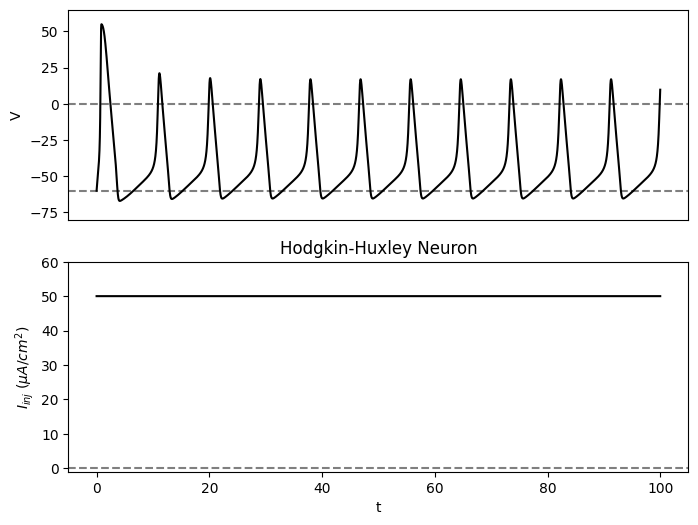

In [3]:
"""
(1. Initialize an hh neuron using the class definition above)
You can find all the corresponding values in the paper
Do not forget to reverse the signs of the one related to voltage!
"""
hh = HodgkinHuxley(
    C_m=1,
    g_Na=120,
    g_K=36,
    g_L=0.3,
    E_Na=115,
    E_K=-12,
    E_L=-10.613,
    T=100,
    dt=0.01,
    reset=-60,
    I_inj=50,
)
#2. Run the hh neuron simulation
hh.run()

#3 plot it
"""
(DO NOT edit the plot code)
"""
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
plt.title("Hodgkin-Huxley Neuron")
ax1.axhline(0, color="k", linestyle="--", alpha=0.5)
ax1.axhline(hh.reset, color="k", linestyle="--", alpha=0.5)
ax1.plot(hh.t, hh.V, "k")
ax1.set_ylabel("V")
ax1.set_ylim(-80, np.max(hh.V) + 10)
ax1.set_xticks([])
ax1.set_xticklabels([])
I_inj = [hh.I_inj for t in hh.t]
ax2.plot(hh.t, I_inj, "k")
ax2.set_xlabel("t")
ax2.axhline(0, color="k", linestyle="--", alpha=0.5)
ax2.set_ylabel("$I_{inj}$ ($\\mu{A}/cm^2$)")
ax2.set_ylim(-1, np.max(I_inj) + 10)
plt.show()

## 1c.
The beauty of a neurophysiologically accurate model of a neuron is that it allows the simulation of several phenomena that can take place in the brain. Assume that you administer a drug named Tetrodotoxin (TTX), which is a potent neurotoxin that inhibits the voltage-gated sodium channels, and therefore decreases the sodium current. Simulate the effects that administering TTX would have on the neural firing.  Do the same for another drug, pronase,
which eliminates sodium inactivation.

Simulating TTX, inhibiting g_Na=0.05*120...


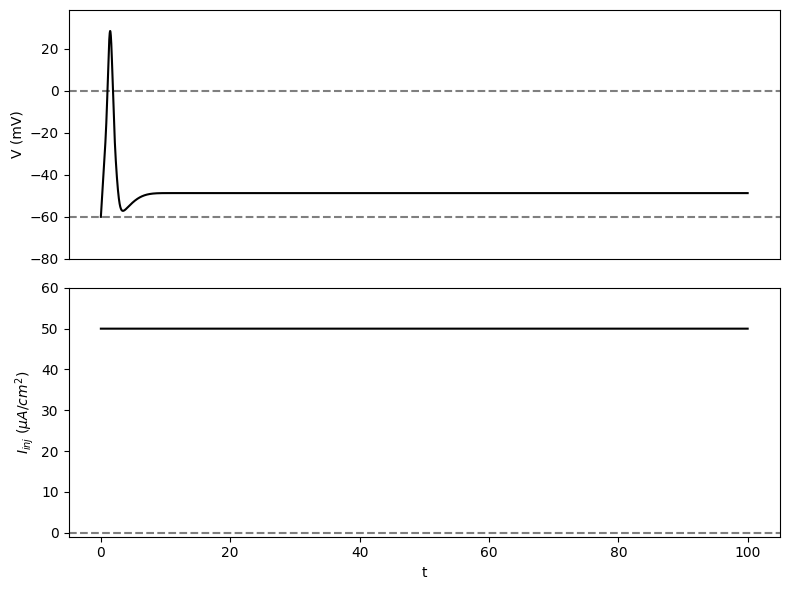

Simulating pronase, making h=1 for complete inactivation...


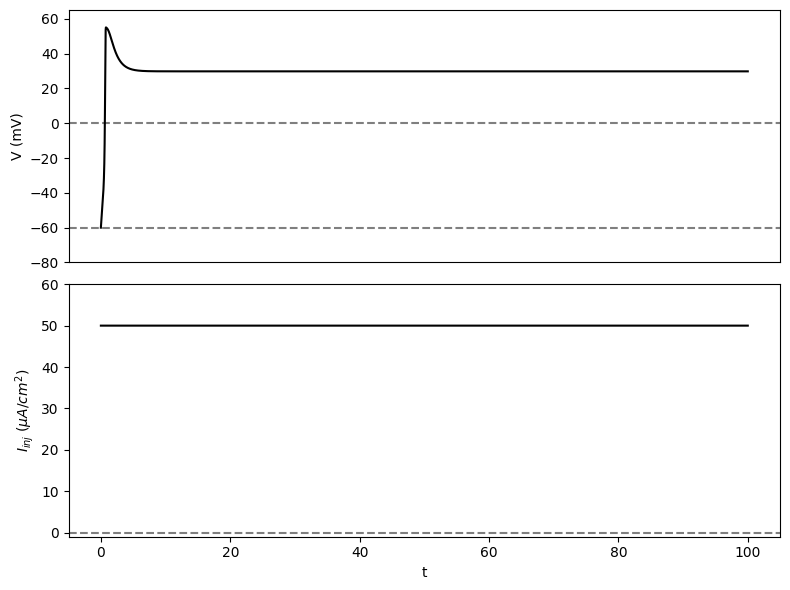

In [4]:
#1. Initialize an hh neuron to simulate TTX
print("Simulating TTX, inhibiting g_Na=0.05*120...")
ttx = HodgkinHuxley(
    C_m=1,
    g_Na=0.05*120,
    g_K=36,
    g_L=0.3,
    E_Na=115,
    E_K=-12,
    E_L=10.613,
    T=100,
    dt=0.01,
    reset=-60,
    I_inj=50,
)

#2. Run the hh neuron simulation
ttx.run()
ttx.plot_results()

#3. Initialize an hh neuron to simulate pronase
print("Simulating pronase, making h=1 for complete inactivation...")
pronase = HodgkinHuxley(
    C_m=1,
    g_Na=120,
    g_K=36,
    g_L=0.3,
    E_Na=115,
    E_K=-12,
    E_L=10.613,
    T=100,
    dt=0.01,
    reset=-60,
    I_inj=50,
)

#4. Run the hh neuron simulation
pronase.run_pronase()
pronase.plot_results()

## 1d. (extra 10 points)

Try to modify the code in the “HodgkinHuxley” class to dynamically show how the HH model will behave as the current magnitude increases. The expected gif results should look like ->

 ![here](./1d.gif)

<ipython-input-2-bf2f4197317c>:276: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(frame_filename)


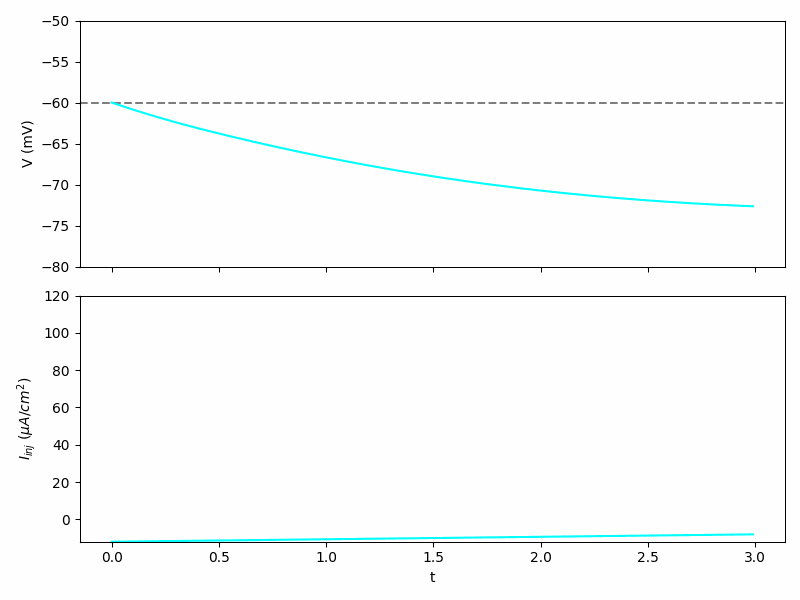

In [5]:
"""
1. Change the color of Spike line to "cyan"
2. the INJECTED current increases from -12 to 120
"""
from IPython.display import Image

hh = HodgkinHuxley(
    C_m=1,
    g_Na=120,
    g_K=36,
    g_L=0.3,
    E_Na=115,
    E_K=-12,
    E_L=10.613,
    T=100,
    dt=0.01,
    reset=-60,
    I_inj=50,
)
hh.plot_gif(start_I=-12, end_I=120, interval=300, color='cyan')
Image(filename='HH_simulation.gif')

# Question 2: The Izhikevich Neuron

## 2a.
We will now implement an Izhikevich (Izhi) neuron model. Below is the class definition of an Izhi neuron. Like before, your task is to fill in the different components required to simulate an Izhi neuron. You should notice one key difference in the implementation: While our HH implementation relied on the odeint libary from scipy for integration, here we will use 'Euler's method' to integrate. The Euler's method is very intuitive, simple, and can be easily implemented. For your reference, the dynamics of an Izhi neuron are described in equations 1, 2, 3 in the paper: https://www.izhikevich.org/publications/spikes.pdf

In [6]:
class Izhi():
    """Implementation of the Izhikevich neuron Model"""
    def __init__(self, a, b, c, d, Vth, T, dt):
        """
        :param a, b, c, d: Izhi neuron parameters
        :param Vth: Voltage threshold for spiking
        :param T: Simulation timesteps
        :param dt: Integration time

        This function is complete. You do not need to do anything here.
        """
        self.a = a
        self.b = b
        self.c = c
        self.d = d
        self.Vth = Vth
        self.u = self.b * self.c #initialize u
        self.T = T
        self.dt = dt
        self.t = np.arange(0, self.T, self.dt)
        self.I = 10 #Input stimulus current

    def run(self):
        """
        Main function to simulate Izhi neuron and plot voltage and current against time. Fill in the update equations for du, dv, v[t] and u[t] and resetting on spiking.
        """
        V = np.zeros(len(self.t)) #Initialize a numpy array containing the membrane voltages for all the timesteps
        V[0] = self.c #Initial membrane voltage is the rest potential, defined by the parameter 'c'
        u = np.zeros(len(self.t)) #Initialize a numpy array containing u for all the timesteps
        u[0] = self.u #Initial u

        for t in range(1, len(self.t)): #the time loop for performing euler's integration
            dv =  (0.04 * V[t-1]**2) + (5 * V[t-1]) + 140 - u[t-1] + self.I
            du =   self.a * ((self.b * V[t-1]) - u[t-1])
            V[t] =  V[t-1] + dv
            u[t] =  u[t-1] + du

            if V[t] >= self.Vth:
                V[t] =  self.c
                u[t] =  u[t] + self.d

        #plotting
        """This function is complete. You do not need to do anything here"""
        plt.figure()
        plt.subplot(2,1,1)
        plt.title('Izhi Neuron')
        plt.plot(self.t, V, 'k')
        plt.ylabel('V')

        plt.figure()
        plt.subplot(2,1,2)
        i_inj = [self.I for t in self.t]
        plt.plot(self.t, i_inj, 'k')
        plt.xlabel('t')
        plt.ylabel('$I_{inj}$ ($\\mu{A}/cm^2$)')

        plt.show()

## 2b.
Initialize an Izhi neuron with the correct parameters and run the simulation. You should again be able to get a plot depicting how the Voltage and Current of the neuron change with time.

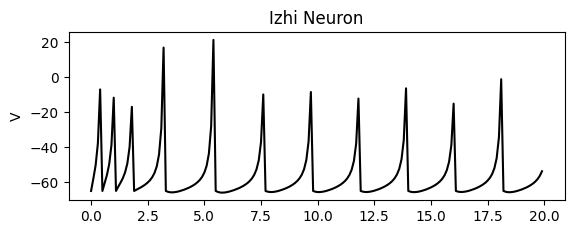

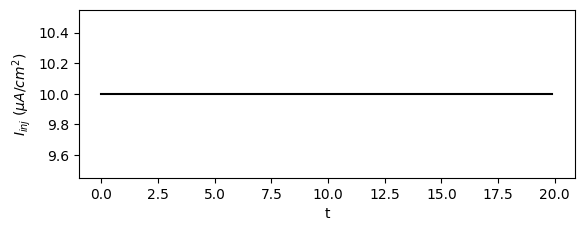

In [7]:
#1. Initialize an izhikevich neuron with the appropriate parameters
regular = Izhi(a=0.02, b=0.2, c=-65, d=2, Vth=30, T=20, dt=0.1)

#2. Run the simulation and obtain the results
regular.run()

## 2c.
Change the parameters of the Izhi neuron in the code to replicate two different patterns identified in neurons, e.g., bursting and adaptation. You can find the parameters for several different Izhi models here: https://www.izhikevich.org/publications/spikes.pdf

Running bursting neuron...


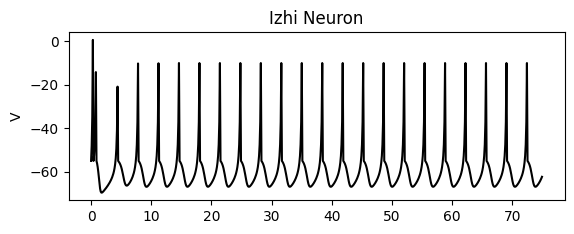

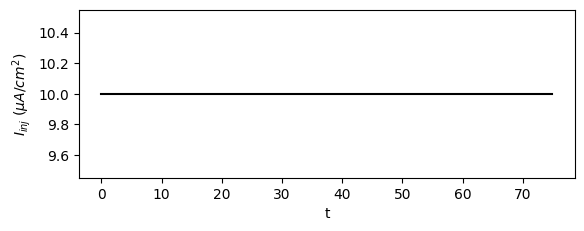

Running chattering neuron...


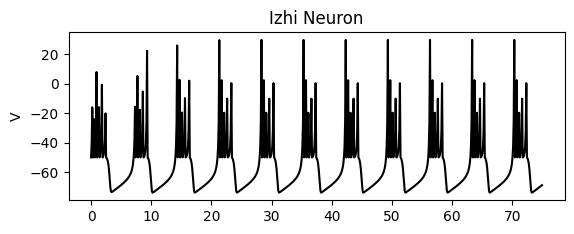

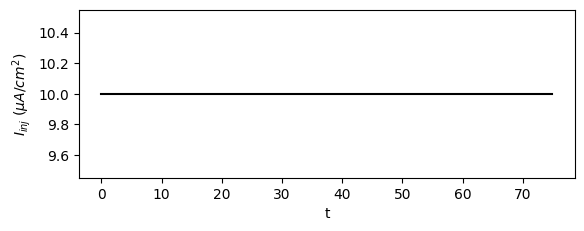

In [8]:
#Write your implementation of the bursting and chattering neuron here
bursting = Izhi(a=0.02, b=0.2, c=-55, d=4, Vth=30, T=75, dt=0.1)
chattering = Izhi(a=0.02, b=0.2, c=-50, d=2, Vth=30, T=75, dt=0.1)

#1. Initialize an izhikevich neuron with the appropriate parameters
print("Running bursting neuron...")
bursting.run()

#2. Run the simulation and obtain the results
print("Running chattering neuron...")
chattering.run()

# Question 3: The LIF Neuron

## 3a.
In this question, you will implement the almighty leaky integrate and fire neuron (LIF). The LIF neuron is the most widely-used model of a neuron in the SNN literature and you will be using it a lot for your course assignments and for your project. Below is the class definition of an LIF neuron. Just like the Izhi neuron, we will use Euler's method to perform integration. There is one key difference however: For HH and Izhi implementations, the neuron was taking current as the input. In our LIF implementation, the neuron takes spike-trains as inputs and produces spike-trains as output, similarly to how a real neuron works.

As a hint, we provide here a discrete-time version of an LIF neuron:

* First, integrate the input spikes into current with some decay factor

$$C[t] = C[t-1] * current\_decay + input\_spike[t]$$

* Then, integrate the current  into voltage with some decay factor

$$V[t] = V[t-1] * voltage\_decay + C[t]$$

* Lastly produce a spike if the voltage exceeds the threshold, and reset voltage

$$if V[t] >= Vth  \\ output\_spike[t] = 1 \ and \ V[t] = Rest\_Potential $$

In [9]:
class LIF():
    """Implementation of Leaky integrate and fire neuron Model"""
    def __init__(self, dc, dv, Vth, Vr):
        """
        :param dc: Decay factor for current
        :param dv: Decay factor for voltage
        :param Vth: Voltage Threshold
        :param Vr: Rest potential

        This function is complete. You do not need to do anything here
        """
        self.dc = dc
        self.dv = dv
        self.Vth = Vth
        self.Vr = Vr

    def run(self, in_spikes):
        """
        Main function to simulate LIF neuron
        :param in_spikes: Input spike train
        :return out_spikes: output spike train

        Fill in the parts for updating Cm, Vm, and the condition for spiking and resetting
        """
        Vm, Cm, out_spikes = [np.zeros(len(in_spikes)) for _ in range(3)] #initialize the state variables
        for t in range(1, len(in_spikes)): #Time loop to perform Euler's Integration
            Cm[t] =  Cm[t-1]*self.dc + in_spikes[t]
            Vm[t] =  Vm[t-1]*self.dv + Cm[t]

            #condition for when membrane potential is greater than the threshold
            if Vm[t] >= self.Vth:
              out_spikes[t] = 1
              Vm[t] = self.Vr
        return out_spikes

## 3b.
Based on the class definition above, create an LIF neuron with the following parameters: dc = 0.5, dv = 0.5, Vth = 0.50, Vr = 0.
Then apply to the neuron a random spike train for 15 timesteps. You might find the following numpy package useful to generate the input spike train:
https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html

Simulate the neuron and print input and output spikes.

In [10]:
np.random.seed(123)

#1. Create an LIF neuron with the required parameters using the class definition above
lif = LIF(dc=0.5, dv=0.5, Vth =0.5, Vr=0)

#2. Generate a random input spike train of 15 timesteps using the numpy random choice library function
input_spikes = np.random.choice([0., 1.], 15)

#3. Print the input spikes
print(f"Input Spikes: {input_spikes}")

#4. Stimulate the LIF neuron with input spikes and return the output spikes
output_spikes = lif.run(input_spikes)

#5. Print the output spikes
print(f"Output Spikes: {output_spikes}")

Input Spikes: [0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0.]
Output Spikes: [0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]


# Question 4: Biology vs. Efficiency
Now that you have simulated spiking neuron models at different levels of abstraction, we will learn how to differentiate between the three neuron models that we have developed, based on the following criteria:
* Biological realism
* Computational Efficiency

Can you describe for what tasks might you need an HH model? For what tasks would an LIF neuron be a better alternative?
*Hint*: Why one should use a neuron model that replicates several of the neuron's mechanisms vs. using a model that emulates the neuron as a spike-in-spike-out black box.

## Answer 4:

| Model                   | Biological Plausibility | Computational Efficiency |
|-------------------------|-------------------------|--------------------------|
| Hodgkin Huxley Neuron   | Good                    | Poor                     |
| Izhikevich Neuron       | Okay                    | Okay                     |
| LIF Neuron              | Poor                    | Good                     |

The **Hodghkin Huxley Neuron** is the most biologically plausible. This neuron model is best suited for tasks like investigating the effects of drugs on ion channels or exploring biophysical properties of disease.

The **Izhikevich Neuron** is somewhat biologically plausible and is somewhat computationally efficient. It's best used for simulating a population of neurons and observing the general distributional learning mechanisms/firing patterns and further understand the human-machine comparison in cognitive science.

The **Leaky Integrate and Fire** neuron is not that biologically plausible but it is the most computational efficient. They are mainly used in understanding neural computation circuits and as modules of larger spiking neural network architectures.

Overall, choosing a more biologically inspired neuron approach enables precise investigations into pharmaceutical effects, disease biophysics, and neural behavior mechanisms. Conversely, opting for a simpler model, such as the Leaky Integrate and Fire neuron, prioritizes computational efficiency over biological detail. This choice is advantageous for developing extensive neural networks and studying neural circuits.




# Question 5: Tuning Membrane Properties of the LIF neuron
## 5a.
In this question, you will understand how to tune the membrane properties of an LIF neuron. First, generate 19 inputs in the form of random spike trains of length 50, i.e. 50 timesteps. The inputs will have different levels of probabilities for spike generation, that ranges between 0.1 and 1.0 with step size of 0.05. In other words, you will create 19 spike trains with the first spike train having the probability of 0.1 to generate spikes at any timestep, the second spike train will have the spike generation probability of 0.15, and so on.

Simulate an LIF neuron with the parameters defined in Question 3b. You will now drive the neuron model with the 19 randomly generated input spike trains that you have created, and compute the output spike train.
At the same time, compute the input firing rate and output firing rate for each simulation. Firing rate is defined as the mean of the spike train, i.e. total number of spikes/timesteps

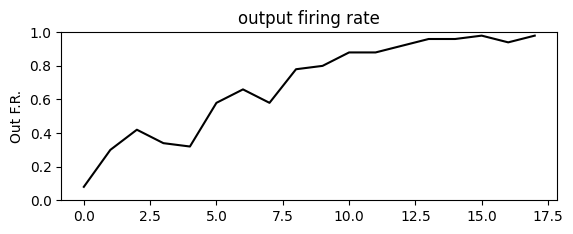

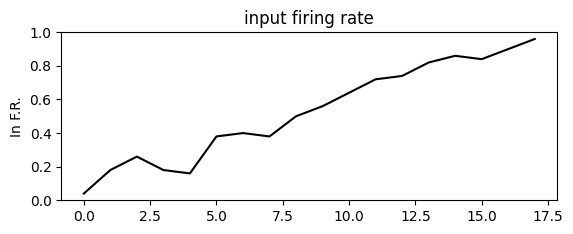

In [11]:
def lif_behavior(lif):
    """Function to understand the behavior of LIF neuron for different densities of spike inputs
    :param lif: An instance of the LIF neuron
    """
    #1. Create lists to store the input and output firing rates
    in_fr = [] #input firing rate
    out_fr = [] #output firing rate

    #2. Create a list of probabilities: from 0.1 to 1.0 with step size of 0.05. You might find the numpy arange function helpful here.
    probabilities = np.arange(0.1, 1.0, 0.05)

    #3. Loop through the range of probabilities
    for p in probabilities:
        in_spikes =  np.random.choice([0., 1.], 50, True, [1-p, p])

        #compute input firing rate and append to the in_fr list
        in_fr.append(sum(in_spikes)/len(in_spikes))

        #obtain output spikes by applying the input to the LIF neuron
        out_spikes = lif.run(in_spikes)

        #compute output firing rate and append to the out_fr list
        out_fr.append(sum(out_spikes)/len(out_spikes))

    #Plot the input and output firing rates. Nothing to do here. This part is complete
    plt.figure()
    plt.subplot(2,1,1)
    plt.title('output firing rate')
    plt.plot(out_fr, 'k')
    plt.ylabel('Out F.R.')
    plt.ylim([0,1])

    plt.figure()
    plt.subplot(2,1,2)
    plt.title('input firing rate')
    plt.plot(in_fr, 'k')
    plt.ylabel('In F.R.')
    plt.ylim([0,1])
    plt.show()

#Run the lif behavior function for the LIF neuron that we created previously
lif_behavior(lif)

## 5b.
Describe how soon does the output firing rate start to saturate? Can you describe why this could be problematic? *Hint: Think from the point of view of distinguishing between two different inputs based on firing activity*

## Answer 5b.
The output firing rate of the LIF neuron model beings to saturate when the input spike train probability starts to exceed $0.65$. This output firing saturation suggests that increasing the input probability beyond this point does not correspond to a substantial increase in the output firing rate. This plateau in firing rate indicates a decreased sensitive of the neuron to higher input rates, which can pose challenges in distinguishing various input intensities.

This lack of sensitivity could lead to information loss, since the neuron model may fail to encode those variations in input stimulus. To address this problem, we could consider adjusting the membrane properties or computational model parameters to prevent premature saturation, ensuring that the neuron's response remains proportional to the input.

## 5c.
Change the membrane properties of the LIF neuron to resolve the issue of saturation. In other words, experiment on setting different parameter values that do not allow the output firing rate to saturate so early. *Hint: You may want to start by changing one variable at a time, and see its effect. Try to move it slightly, or abruptly, up or down. Then move to the next parameter, until you see what is its effect on the neuron's output.*

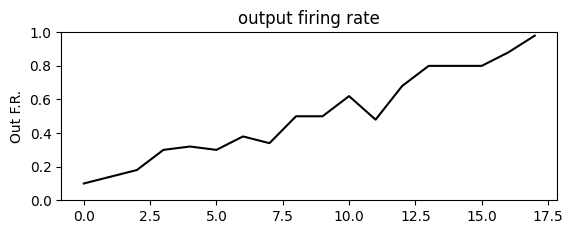

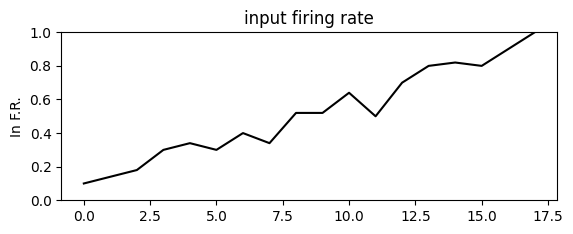

In [12]:
#1. Create an LIF neuron with appropriately tuned membrane properties
lif_updated = LIF(dc=0.1, dv=0.5, Vth =0.5, Vr=0)

#2. Call the lif behavior function on the tuned lif neuron
lif_behavior(lif_updated)

## 5d.
Based on the above results, can you describe how changing the H-H parameters changes the voltage threshold of a spiking neuron as a function of the input spikes?

## Answer 5d.
In the LIF neuron model, we see that reducing the DC input reduces neuron saturation: a lower baseline current reduces the chance for the neuron to reach the firing threshold with lower-frequency input spikes. The resulting firing rate curve demonstrates a more linear relationship with input spike firing rates.

Applied to the Hodgkin-Huxley model, similar ideas apply: modulating parameters for ion channel conducatance help determine neuron's threshold for firing. For example, decreasing sodium conductance or increasing potassium conductance could increase the voltage threshold, which in turn would require a higher frequency or greater intensity of input spikes to elicit an action potential, therefore reducing the chance of saturation.

# Question 6: Encoding continuous inputs into spikes
## 6a.
Now we will understand how we can represent continuous-valued inputs as spikes so that drive our spiking neuron. Describe two prominent ways to encode a continuous-valued input into the spiking activity of a neuron.

## Answer 6a.
- **Rate Coding:**  Rate coding represents the strength of an input stimulus by the average firing rate of a neuron – stronger stimuli produce higher spike frequency.
- **Latency Coding:** Latency coding encodes stimulus intensity through the timing of the first spike –  stronger stimuli evoke earlier spikes, while weaker stimuli induce later spikes. This strategy has potential benefits for energy efficiency by potentially reducing the overall number of spikes.


## 6b.
So far we have learned how we can stimulate a spiking neuron using spike inputs. In this exercise, you will learn how to encode real-world data into spikes that can then be fed as inputs to the spiking neuron. We will take a digit from the popular MNIST dataset as an example. First let's see what a sample digit from the MNIST image looks like. For this, we need to create a loader for the MNIST dataset using a Pytorch function called datasets.MNIST. You do not need to know what a loader is for now. Just understand the two important arguments of the function: The first argument is the directory where the MNIST dataset will be downloaded. The third argument is the set download option. This should be true for the first time when you run this cell to allow you to download the MNIST data into your directory. You can set it to false if the MNIST data has already been downloaded.

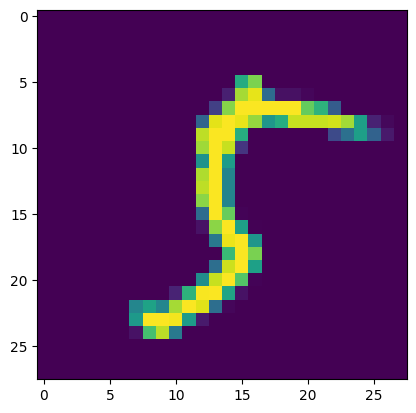

In [13]:
import random

#Create a loader
mnist = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

#You can access any sample digit from the MNIST dataset using simple indexing mnist[idx]. This returns the digit and the label. We are only interested in the digit.
x, _ = random.choice(mnist)
# x, _ = mnist[24] # uncomment this line if you want to fix the target image

#Convert to numpy
x = x.numpy()[0]

#Visualize
plt.imshow(x)

Let's now encode the image in the form of spikes using rate-encoding. Suppose that each pixel in the image needs to be encoded in a spike train of length 1. The steps to encode are outlined below:
* For each pixel in the image, sample a random number.
* If the pixel intensity is greater than the generated random number, output a spike.
* Repeat for as many timesteps as you need to encode the image for.
* Repeat for all pixels

In [14]:
#0. Decide the number of spike train here. let us say n_spike = 1 here.
n_spike = 1

#1. Use the numpy.random.rand function to encode the MNIST image into spikes
def encode_spikes(image, n_spike):
    spike_encoded_image = np.zeros((n_spike,) + image.shape)
    for t in range(n_spike):
        random_matrix = np.random.rand(*image.shape)
        spike_encoded_image[t] = image > random_matrix
    return spike_encoded_image

#2. Output the shape of the spike-encoded image using numpy.shape (hint: the spike-encoded image should be a 3d arraay)
spike_encoded = encode_spikes(x, n_spike)
print("Shape of spike-encoded image:", np.shape(spike_encoded))

Shape of spike-encoded image: (1, 28, 28)


## 6c.
Now, we will decode the image back from the spike-based representation. Can you think of a way to get the pixel values back? *Hint: Think aggregate measures on the spike trains for each pixel. Aggregation means compressing of the channel from n to 1.*

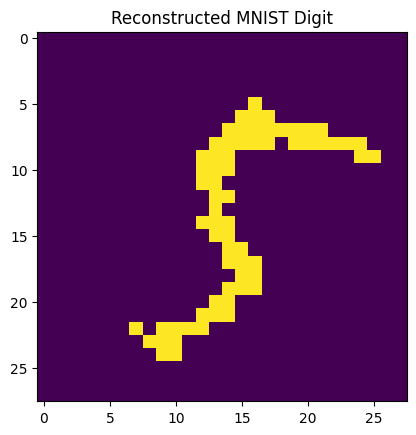

In [15]:
#1. Compute some aggregate measure of spike trains for each pixel to get the image back. Numpy aggregate functions might be useful here
def decode_spikes(spike_encoded):
    decoded_image = np.mean(spike_encoded, axis=0)
    return decoded_image

#2. visualize the reconstructed image
decoded_image = decode_spikes(spike_encoded)
plt.imshow(decoded_image)
plt.title("Reconstructed MNIST Digit")
plt.show()

Is it possible to get the exact image back? Why/Why not?

## Answer 6c.
No, it is not possible because the encoding process is lossy. Basically, every input pixel in the range [0,255] is now mapped to [0,1] at each pixel, meaning that some information is lost. Binarizing the data loses some information, even though we can capture some salient details.

## 6d.
Can you think of a way to encode the image into spikes in a way such that the decoded image looks as close as possible to the original image? *Hint: Think timesteps*

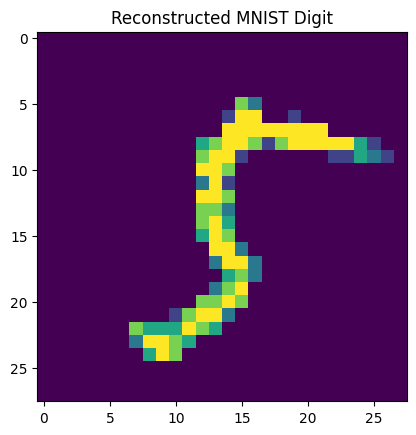

In [16]:
#1. Create a "better" encoding of the image
spike_encoded = encode_spikes(x, n_spike=5)

#2. Compute and visualize the decoded image
decoded_image = decode_spikes(spike_encoded)
plt.imshow(decoded_image)
plt.title("Reconstructed MNIST Digit")
plt.show()

If each intensity pixel is represented with a value between [0, 255], what would be a reasonable timestep to encode it accurately? What might be a disadvantage of this solution?

## Answer 6d.
An 8-timestep spike encoding can completely represent pixel intensities between 0 and 255 by using binary representation ($2^8=256$ values), where each timestep corresponds to a bit position and the presence or absence of a spike represents a 1 or 0, respectively.

This method is highly efficient in terms of temporal resources, requiring only 8 timesteps regardless of the intensity, and it aligns well with digital binary systems, allowing for straightforward encoding and decoding processes.

However, this assumes a level of precision in spike timing that may not be realistic in biological systems due to stochasticity and, furthermore, this relies on a decoder that can interpret binary patterns

## 6e

Can you try at least **two** other aggregation functions to decode the images and describe the differences among them.

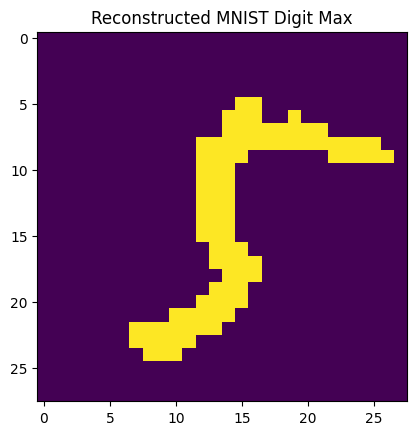

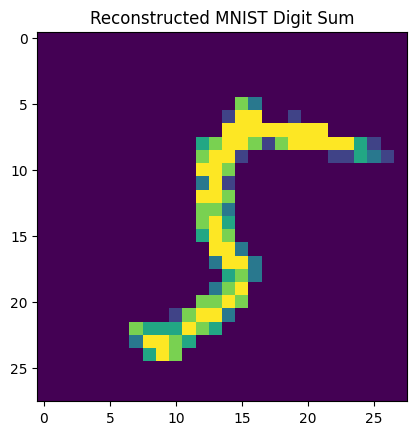

In [17]:
#1 same struction as 6c
def decode_spikes_max(spike_encoded):
    decoded_image = np.max(spike_encoded, axis=0)
    return decoded_image

def decode_spikes_sum(spike_encoded):
    decoded_image = np.sum(spike_encoded, axis=0)
    return decoded_image

#2 plot the results
decoded_image = decode_spikes_max(spike_encoded)
plt.imshow(decoded_image)
plt.title("Reconstructed MNIST Digit Max")
plt.show()

decoded_image = decode_spikes_sum(spike_encoded)
plt.imshow(decoded_image)
plt.title("Reconstructed MNIST Digit Sum")
plt.show()

## Answer 6e.
**Max** selects the highest spike value within a pixel, highlighting peak intensity but potentially losing information from sparse spike patterns. **Sum** integrates all spikes within a pixel, giving a better measure of overall activity and preserving subtle intensity variations. Visually, **max** may produce higher contrast but less detail, while **sum** may yield a smoother, more nuanced image.
